In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import wordnet,stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
words_counts = {}

wnl = WordNetLemmatizer()
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def stem(sentence):
    lemmas_sent = []
    tagged_sent  = pos_tag(sentence)
    for tag in tagged_sent:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        lemmas_sent.append(wnl.lemmatize(tag[0], pos = wordnet_pos))
    return lemmas_sent

def read_data(filename):
    data = pd.read_csv(filename).drop(['Unnamed: 0'], axis = 1).dropna()
    return data

def text_preprocess(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS and not(word.isdigit()))
    return stem([text])

ALL_WORDS = []
words_counts = {}
y = []
for i in range(1, 1001):
    for text in read_data('./dataset/' + str(i) + '.csv')['abstract'].values:
        temp = []
        for word in text_preprocess(text)[0].split():
            temp.append(word)
            if word not in words_counts: 
                words_counts[word] = 0
            words_counts[word] += 1
        ALL_WORDS.append(temp)
        y.append(0)
    for text in read_data('./dataset2/' + str(i) + '.csv')['abstract'].values:
        temp = []
        for word in text_preprocess(text)[0].split():
            temp.append(word)
            if word not in words_counts: 
                words_counts[word] = 0
            words_counts[word] += 1
        ALL_WORDS.append(temp)
        y.append(1)


In [2]:
from gensim.models.word2vec import Word2Vec
def most_similar(wv_model, words, topn):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(wv_model.wv.most_similar(word, topn = topn), columns = [word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis = 1)
        except:
            print(word, "not found in Word2Vec model")
    return similar_df

In [3]:
model = Word2Vec(ALL_WORDS, vector_size = 50, epochs = 12, min_count = 1, negative = 5, workers = 5, sg = 0, window = 4)
model.save("word2vec.model")
sim_word = most_similar(model, ['covid19'], 15)
sim_word

,covid19,cos
0,sarscov2,0.720770
1,covid,0.675972
2,adjudicating,0.551471
3,ongoing,0.529913
4,israelis,0.522305
5,hcws,0.515876
6,2019ncov,0.506065
7,covid_19,0.502776
8,initial,0.496008
9,infection,0.495532


In [4]:
model_sg = Word2Vec(ALL_WORDS, vector_size = 50, epochs = 12, min_count = 1, negative = 5, workers = 5, sg = 1, window = 4)
model_sg.save("word2vec_sg.model")
sim_word_sg = most_similar(model_sg, ['covid19'], 15)
sim_word_sg

,covid19,cos
0,disease2019,0.819513
1,sarscov2,0.797288
2,disease19,0.792200
3,bloodoncology,0.784973
4,controllable,0.775202
5,covid19infected,0.773312
6,infection,0.770448
7,2019coronavirus,0.768896
8,coronavirus,0.764315
9,covert,0.763554


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD 
from sklearn.manifold import TSNE

def display_pca_scatterplot(model, words, search_name = 'covid19'):
    word_vectors = np.array([model.wv[w] for w in words if w != search_name])
    dot = np.array([model.wv[search_name]])
    twodim = PCA().fit_transform(word_vectors)[:, :2]
    twodim_dot = PCA().fit_transform(dot)[:2]

    plt.figure(figsize=(7, 4))
    plt.scatter(twodim[:, 0], twodim[:, 1], edgecolors = 'k', c = 'b', marker="x")
    plt.scatter(twodim_dot[0], twodim_dot[0], edgecolors = 'k', c = 'r', marker="x")
    plt.text(twodim_dot[0] + 0.05, twodim_dot[0] + 0.05, search_name)
    plt.show()

most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)
match_words = []
match_words_sg = []
for i in range(15):
    if most_common_words[i][0] in model.wv:
        match_words.append(most_common_words[i][0])
    if most_common_words[i][0] in model_sg.wv:
        match_words_sg.append(most_common_words[i][0])

C:\Users\iir\anaconda3\envs\tfenv\lib\site-packages\sklearn\decomposition\_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
C:\Users\iir\anaconda3\envs\tfenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  
C:\Users\iir\anaconda3\envs\tfenv\lib\site-packages\ipykernel_launcher.py:15: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  from ipykernel import kernelapp as app


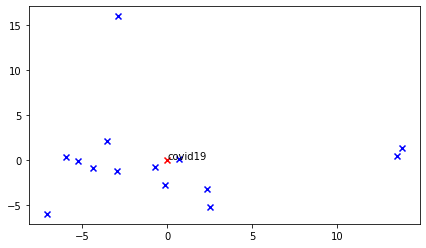

In [6]:
display_pca_scatterplot(model, match_words)

C:\Users\iir\anaconda3\envs\tfenv\lib\site-packages\sklearn\decomposition\_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
C:\Users\iir\anaconda3\envs\tfenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  
C:\Users\iir\anaconda3\envs\tfenv\lib\site-packages\ipykernel_launcher.py:15: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  from ipykernel import kernelapp as app


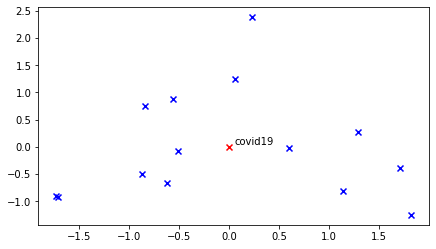

In [7]:
display_pca_scatterplot(model_sg, match_words)

In [8]:
sorted_word = []
sorted_num = []
for data in most_common_words:
    sorted_word.append(data[0])
    sorted_num.append(data[1])

In [9]:
pd.DataFrame(ALL_WORDS).to_csv('words.csv', index=False )
pd.DataFrame([sorted_word, sorted_num]).T.to_csv('dict_words.csv', index=False )

In [ ]:
MLP = []
for i in range(len(ALL_WORDS)):
    temp = [0] * 50
    for word in ALL_WORDS[i]:
        for j in range(50):
            temp[j] += model_sg.wv[word][j]
    for j in range(50):
        try:
            temp[j] = round(temp[j] / len(ALL_WORDS[i]), 4)
        except:
            temp[j] = 0
    MLP.append(temp)

In [ ]:
# model_MLP = Sequential()
# model_MLP.add(Dense(512, activation='relu', input_shape=(50,)))
# model_MLP.add(Dense(256, activation='relu'))
# model_MLP.add(Dense(128, activation='relu'))
# model_MLP.add(Dense(64, activation='relu'))
# model_MLP.add(Dense(1, activation = 'softmax'))
# model_MLP.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# model_MLP.summary()

In [ ]:
# model_MLP.fit(np.array(x_train), np.array(y_train), epochs = 10, batch_size = 128

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, average_precision_score
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

def print_evaluation(y_val, y_val_pred):
    accuracy = accuracy_score(y_val, y_val_pred)
    f1_score_macro = f1_score(y_val, y_val_pred, average='macro')
    f1_score_micro = f1_score(y_val, y_val_pred, average='micro')
    precision_macro = average_precision_score(y_val, y_val_pred, average='macro')
    precision_micro = average_precision_score(y_val, y_val_pred, average='micro')
    print('accuracy:', accuracy)
    print('F1-score macro:', f1_score_macro)
    print('F1-score micro:', f1_score_micro)
    print('Precision macro:', precision_macro)
    print('Precision micro:', precision_micro)
    
x_train, x_test, y_train, y_test = train_test_split(MLP, y, test_size = 0.20, random_state = 0)
model_MLP = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(10), activation="relu", solver='adam', alpha = 0.0001, learning_rate_init = 0.001,max_iter = 200)).fit(np.array(x_train), np.array(y_train))
predicted = model_MLP.predict(np.array(x_test))
print_evaluation(y_test, predicted)


In [ ]:
from joblib import dump, load
dump(model_MLP, 'model_MLP.joblib') 

In [ ]:
clf = load('model_MLP.joblib') 
predicted = clf.predict(x_test)
print_evaluation(y_test, predicted)